# Introduction

In this notebook we will explore the concept of agents in the LlamaIndex framework. Creating an agent-based pipeline includes integrating our RAG-based application with data sources along with various tools. It is essential to remember that developing these tools for the agents requires are likely to engage with the application and predict potential usage patterns.

The LlamaIndex framework offers numerous possibilites for combining agents and tools to enhance the abilities or LLM's. So, in this lesson we will demonstrate how these agents are capable of making decisions and integrating various resources to formulate a response.

Before start coding, we have to prepare the enviroment and settings.

In [9]:
from llama_index.core import Settings
from langchain_ollama import OllamaEmbeddings, OllamaLLM

Settings.embed_model = OllamaEmbeddings(model="llama3.1:8b")
Settings.llm = OllamaLLM(model="llama3.1:8b")


KeyboardInterrupt: 

# Creation of a RAG agent with custom tools

It's always interesting to tag and track data sources from the start. This mean giving a tag and it's source/origin to each document. By doing this, we will improve the chatbot's efficiency. To to this, we will introduce the `routers` to focus on the related information source to answer a question.

A key step in building a data-driven application with the LlamIndex RAG system is selecting the appropiate dataset. The quality and relevance of the data are fundamental. It's a good practice to start your RAG pipeline design with a small dataset, such as web articles. This way, you can quickly test, debug and understand your RAG system.

In this notebook we will use the dataset of Nikola Tesla's life, work and legacy. We employ two text documents: the first with bold future prediction that Tesla mentioned during his lifetime and the second file with biographical details about his life. We will store both documents into local files.

In the following code, we create a folder and we download the files to save them into the recently created folder:

In [ ]:
!mkdir data\1k
!curl -o data\1k\tesla.txt https://raw.githubusercontent.com/idontcalculate/data-repo/main/machine_to_end_war.txt
!curl -o data\1k\web.txt https://raw.githubusercontent.com/idontcalculate/data-repo/main/prodigal_chapter10.txt

Ya existe el subdirectorio o el archivo data\1k.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 13902  100 13902    0     0  21352      0 --:--:-- --:--:-- --:--:-- 21420
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 23243  100 23243    0     0  41686      0 --:--:-- --:--:-- --:--:-- 41803


In [ ]:
from llama_index.core import Settings
from langchain_ollama import OllamaEmbeddings
from langchain_ollama import OllamaLLM

Settings.embed_model = OllamaEmbeddings(model="llama3.1:8b") # Load it into the setting of llama index
Settings.llm = OllamaLLM(model="llama3.1:8b")

Now, we read the first document and process it to store in Deep Lake.

The next step is to establish a database on the Activeloop platform and upload the embeddings.

In [ ]:
from llama_index.core import load_index_from_storage
from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext, VectorStoreIndex



tesla_docs = SimpleDirectoryReader(input_files=["data/1k/web.txt"]).load_data()

try:
    # Try to load the index if it is already calculated
    storage_context = StorageContext.from_defaults(persist_dir="storage/tesla")
    tesla_index = load_index_from_storage(storage_context=storage_context)
    print("Loaded the pre-computed index.")
except:
    # Otherwise, generate the indexes
    tesla_index = VectorStoreIndex.from_documents(tesla_docs)
    tesla_index.storage_context.persist(persist_dir="storage/tesla")
    print("Generated the index.")



Loaded the pre-computed index.


The next step is to store the embeddings of the other document locally.

In [ ]:
from llama_index.core import load_index_from_storage

webtext_docs = SimpleDirectoryReader(input_files=["data/1k/web.txt"]).load_data()

try:
    # Try to load the index if it is already calculated
    storage_context = StorageContext.from_defaults(persist_dir="storage/webtext")
    webtext_index = load_index_from_storage(storage_context=storage_context)
    print("Loaded the pre-computed index.")
except:
    # Otherwise, generate the indexes
    webtext_index = VectorStoreIndex.from_documents(webtext_docs)
    webtext_index.storage_context.persist(persist_dir="storage/webtext")
    print("Generated the index.")



Loaded the pre-computed index.


### RAG tools

After generating the vector store indexes, the next step is to create the query engine.

In [ ]:
tesla_engine = tesla_index.as_query_engine(similarity_top_k=3)
webtext_engine = webtext_index.as_query_engine(similarity_top_k=3)

The `tesla_engine` variable handles queries about general information, and `webtext_engine` variable processes biographical data, focusing on inputs with a factual content.

Now that the query engines are constructed, the tools can be configured. We can use a combination of the `QueryEngineTool` class to create a new tool that includes a query engine and the `ToolMetaData` class, which assists in assingning names and descriptions to the tools. These descriptions will help the agent to determine the most suitable data source based on the user's query. We will create a list of two tools, each representing one of out data sources.

In [ ]:
from llama_index.core.tools import QueryEngineTool, ToolMetadata

query_engine_tool_tesla = QueryEngineTool(
    query_engine=tesla_engine,
    metadata=ToolMetadata(
        name="tesla_1k",
        description=(
            "Provides information about Tesla's statements that refers to future times and predictions."
            "Use a detailed plain text text question as input to the tool."
        )
    )
)
query_engine_tool_webtext = QueryEngineTool(
    query_engine=webtext_engine,
    metadata=ToolMetadata(
        name="webtext_1k",
        description=(
            "Provides information about tesla's life and biographical data."
            "Use a detailed plain text question as input to the tool."
        )
    )
)

query_engine_tools =[query_engine_tool_tesla, query_engine_tool_webtext]

Finally, we create the agent.

In [ ]:
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain.agents import create_react_agent, create_tool_calling_agent
from langchain.agents.agent import AgentExecutor
from langchain_ollama import ChatOllama


# First, we convert the LlamaIndex tools to LangChain tools
query_engine_tools_llamaindex_to_langchain = [t.to_langchain_tool() for t in query_engine_tools]

# After that, we create a system context for the agent 
system_context = "You are an expert about Nikola Tesla.\
You will answer questions about his life and future predictions"

# We create the prompt for the chat
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_context,
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

llm_chat = ChatOllama(model="llama3.1:8b")

# Construct the Tools agent
agent = create_tool_calling_agent(llm=llm_chat, tools=query_engine_tools_llamaindex_to_langchain, prompt=prompt)
# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=query_engine_tools_llamaindex_to_langchain, verbose=True, return_intermediate_steps=True, handle_parsing_errors=True, max_iterations=10)

Once we've created the agent executor, we can pass a query to the agent.

In [ ]:
question =  "What influenced Nikola Tesla to become an inventor?"

response = agent_executor.invoke({"input": question})
print("\nFinal Response:", response['output'])



> Entering new AgentExecutor chain...

Invoking: `webtext_1k` with `{'input': 'What influenced Nikola Tesla to become an inventor?'}`




c:\Users\aleja\OneDrive\Escritorio\Cursos\RAG Course ActiveLoop\RAGCourse\Lib\site-packages\llama_index\llms\langchain\base.py:106: LangChainDeprecationWarning: The method `BaseLLM.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  output_str = self._llm.predict(prompt, **kwargs)


Based on the provided text, it does not explicitly state what influenced Nikola Tesla to become an inventor. However, it can be inferred that his curiosity and fascination with electricity and vibrations likely played a significant role in shaping his interest in inventing.

Tesla's observation of objects responding differently to vibrations and his desire to explore this phenomenon further suggest a natural inclination towards scientific inquiry and experimentation. His focus on understanding the properties of sustained powerful vibrations and attempting to demonstrate its effects on a large scale indicate a passion for discovery and innovation, which are hallmarks of an inventor.

Therefore, while the text does not provide direct evidence of what influenced Tesla's interest in inventing, his actions and thought processes depicted in the narrative suggest that his curiosity about electricity and vibrations likely played a significant role in shaping his inventive endeavors.However, I 

We can observe how the agent invoked the `webtext` retriever to get information, analyzed the provided information and gave a final response. 

### Custom tools

Finally, we can create the some custom tools to solve mathematical operations that LLM's tend to fail. To to do that, we must define a custom fuction tailored to each task.

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool, Tool

class multiply_input(BaseModel):
    a : int = Field(..., description="First integer for the multiply operation")
    b : int = Field(..., description="Second integer for the multiply operation")

@tool(args_schema=multiply_input)
def multiply(a:int, b:int)->int:
    """
    Multiply two integers.
    """
    return a*b

class add_input(BaseModel):
    a : int = Field(..., description="Firs integer for add operation")
    b : int = Field(..., description="Second integer for the add operation")

@tool(args_schema=add_input)
def add(a:int, b:int)->int:
    """
    Add two integers.
    """
    return a+b

Once we have created the methods, we transform them to tools that can be used by the agent.

In [ ]:
all_tools = [multiply, add]
tool_names = ["multiply", "add"]

These tools can be used to construct an `ObjectIndex`, which is a wrapper class linking a `VectorStoreIndex` with multiple possible tools. Intially, it's necessary to utilize the `SimpleToolNodeMapping` tool to transform the tool implementatiosn into nodes and then tie everything together.

In [ ]:
from langchain_core.output_parsers.string import StrOutputParser

system_context = "You are an assistant for mathematical operations.\
    You will answer to mathematical questions."

# We create the prompt for the chat
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_context,
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

llm_chat = ChatOllama(model="llama3.1:8b")

# Construct the Tools agent
agent = create_tool_calling_agent(llm=llm_chat, tools=all_tools, prompt=prompt)
# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=all_tools, verbose=True, return_intermediate_steps=True, handle_parsing_errors=True, max_iterations=10)

In [ ]:
question_add =  "What is the result of adding 3 to 5"
response_add= agent_executor.invoke({"input": question_add})
print("\nFinal Response:", response_add['output'])

question_mult =  "What is the result of multiplying 3 to 5"
response_mult= agent_executor.invoke({"input": question_mult})
print("\nFinal Response:", response_mult['output'])



> Entering new AgentExecutor chain...

Invoking: `add` with `{'a': 3, 'b': 5}`


8


> Finished chain.

Final Response: 8


> Entering new AgentExecutor chain...

Invoking: `multiply` with `{'a': 3, 'b': 5}`


15


> Finished chain.

Final Response: 15


As we can see, we have been able to create an agent that is able to solver mathematical questions. As we can see, we've created a new agent that has no access to the RAG tools that we implemented before.

However, **can we implement a multi-agent system?. We will show the alternatives for this problem in the next section.**

# Multi-agent systems

When we are talking about multi-agent, we are talking bout multiple independent actors powered by language models connected in a specific way. Each agent can have it's own prompt, LLM, tools and other custom code to best collaborate with the other agents. These annotations has been followed this [post](https://blog.langchain.dev/langgraph-multi-agent-workflows/) from LangChain's blog.

We can immagine agents as nodes in a graph, and their connections are represented as an edge. The control flow is managed by edges, and they communicate by adding to the graph's state.

The main benefits of multi-agent systems are:

-   Grouping tools can give better results. An agent is more likely to suceed on a focused task.
-   Separate prompts can give better results. Each prompt can have it's own instructions and few-shot examples. Each agent could be powered by a separate fine-tuned LLM.
-   You can evaluate and improve each agent individually without breaking the larger application.

Multi-agent designs allow you to divide complicated problems into tractable units of work that can be targeted by specialized agents and LLM programs. In the next steps we will implement examples of different architectures:

## Multi-agent collaboration

**NOTE**: In this section we have created a different architecture than the provided in the first graph. Pleaso scroll down to see thi final implementation

In this example, the different agents collaborate on a shared scratchpad of messages. This means that all the work either of them do is visible to the other. This has the benefit that other agents can see all the individual steps done. This has the downside that sometimes is it overly verbose and unnecessary to pass ALL this information along, and sometimes only the final answer from an agent is needed. We call this collaboration because of the shared nature the scratchpad.

In this case, the independent agents are actually a single LLM call. Specifically, they are a specific prompt template (to format inputs in a specific way with a specific system message) plus an LLM call.

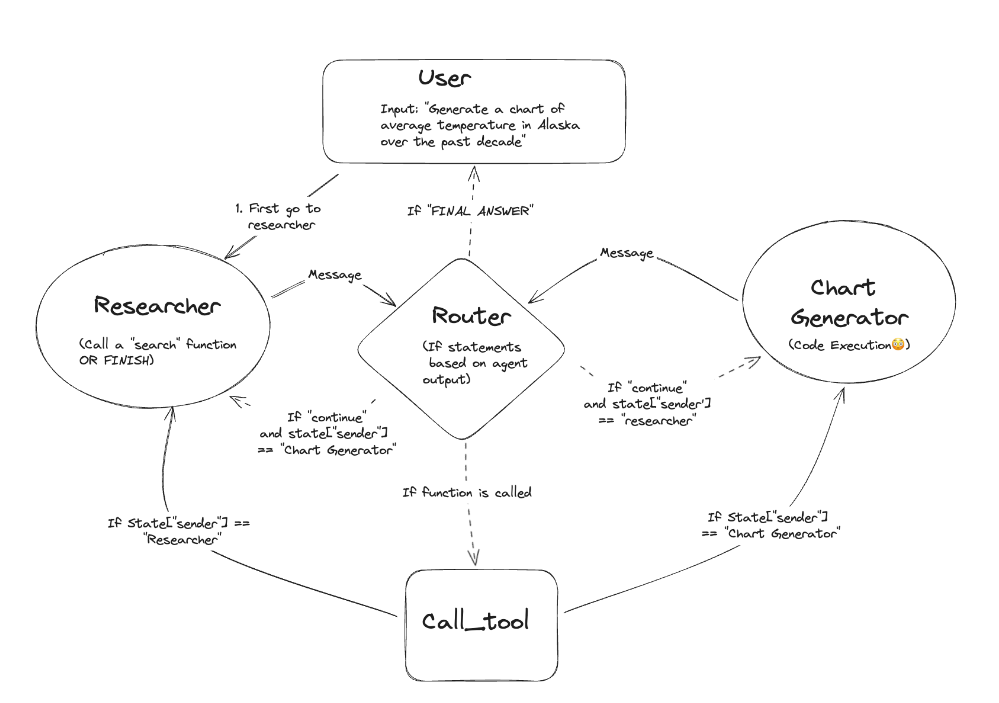

The main thing controlling the state transitions is the router, but it is a rule-based router and so is rather quite simple. Basically, after each LLM call it looks at the output. If a tool is invoked, then it calls that tool. If no tool is called and the LLM responds "FINAL ANSWER" then it returns to the user. Otherwise (if no tool is called and the LLM does not respond "FINAL ANSWER") then it goes to the other LLM.

But first, we have to difference between agent and node:

-   *Agent*: An agent is an entity that leverages a language model (LLM) and tools to perform specific tasks based on user inputs. Agents are designed to execute particular functions, such as answering questions, generating content, or performing calculations. For example, in your code, the `chart_agent` is created specifically to generate charts, utilizing a specific language model and tools like `python_repl` for executing Python code.
-   *Node*: A node, on the other hand, is a point of interaction that represents the behavior of an agent within a larger system. It serves as a function that manages how an agent interacts with other components of the system. The node is responsible for processing the agent's output (whether it’s a tool message or an AI message) and returning it in a specified format. In your code, the `agent_node` function creates a node for a specific agent, allowing for consistent handling of the agent's responses.

We start creating a method to create the agent for this system.

In [ ]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

def create_agent(llm, tools, system_message):
    """Create an agent"""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a helpful AI assistant, collaborating with other assistants.
                Use the provided tools to progress towards answering the question."
                If you are unable to fully answer, that's OK, another assistant with different tools 
                will help where you left off. Execute what you can to make progress.
                If you or any of the other assistants have the final answer or deliverable,
                prefix your response with FINAL ANSWER so the team knows to stop.
                You have access to the following tools: {tool_names}.\n{system_message}""",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message) # Include the value of the variable "system_message"
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools])) # Include the value of the variable "tool_names"
    return prompt | llm.bind_tools(tools) # Return chain with prompt and LLM with the tools binded

The unique tool is the research tool.

In [ ]:
from langchain_community.tools import DuckDuckGoSearchResults

research_tool = DuckDuckGoSearchResults(max_results=10, output_format="list")

The next step is to define the state of the graph. This will be just list of messages, along with a key to folow the most recent sender.


In [ ]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

# This defines the object that is passed between each node in the graph. We will create different nodes for each agent and tool.
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

Define the agent nodes

In [ ]:
from langchain_ollama import ChatOllama
import functools

# Helper method to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages":[result],
        "sender":name
    }

llm = ChatOllama(model="qwen2.5:14b")

summ_agent = create_agent(
    llm=llm,
    tools=[],
    system_message="""You have to create a summary and extract the keywords from the given text.
    If you consider you have created a nice summary, add FINAL ANSWER to your asnwer.
    """,
)
# Create chart node
summ_node = functools.partial(agent_node, agent=summ_agent, name="Summaryzer") # Define the node and introduce some of the variable's values


# Research agent
research_agent = create_agent(
    llm=llm,
    tools=[research_tool],
    system_message="You should organize the information you receive for better understanding."
)
# Create research node
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


Finally, we define a tool node to run the tools.

In [ ]:
from langgraph.prebuilt import ToolNode

tools = [research_tool]
tool_node = ToolNode(tools)


We can also define some of the edge logic that is needed to decide what to do based on results of the agents.

In [ ]:
from typing import Literal

def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

Finally, we define the graph of the nodes, router and the tool node.

In [ ]:
from langgraph.graph import StateGraph

workflow = StateGraph(AgentState) # Degfine the structure of an agent state
workflow.add_node("Summaryzer", summ_node)
workflow.add_node("Researcher", research_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Summaryzer", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "Summaryzer",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", END: END}
)
workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Summaryzer": "Summaryzer",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()


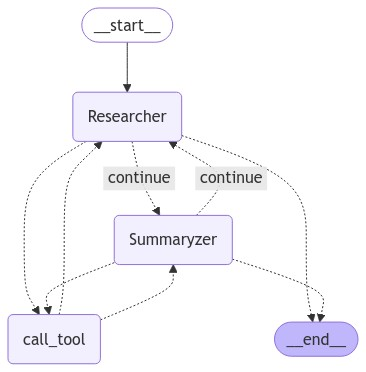

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the last news from United States,"
                " Then create a summary of them"
                " Once you have the summary, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 50},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2024-11-01T10:59:57.2734642Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'duckduckgo_results_json', 'arguments': {'query': 'last news from United States'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 4110694200, 'load_duration': 82026900, 'prompt_eval_count': 315, 'prompt_eval_duration': 843908000, 'eval_count': 27, 'eval_duration': 3177394000}, name='Researcher', id='run-c9935f68-d137-4831-a811-19aa5b085eca-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'last news from United States'}, 'id': '80dce5cb-cc2d-45e0-9bfd-bbfe1a15d683', 'type': 'tool_call'}], usage_metadata={'input_tokens': 315, 'output_tokens': 27, 'total_tokens': 342})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='snippet: United States category Pro-Trump poll watchers primed for

In [ ]:
s['Summaryzer']['messages'][0].content

' \n\n**Keywords:** Pro-Trump, poll watchers, election day, premature infant formula, liability cleared, mass shootings\n\nFINAL ANSWER'

## Agent Supervisor

In an agent supervisor architecture, we can use an LLM to orchestrate the different agents.

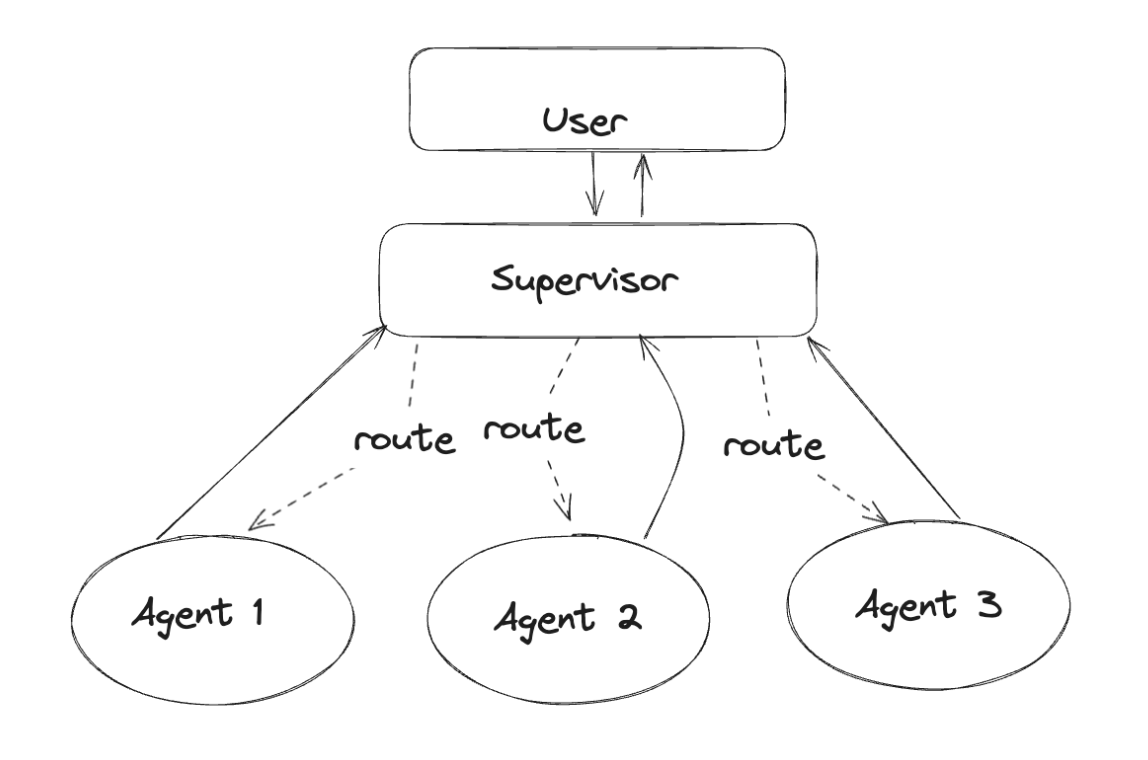

To simplify the code in each agent node, we will use LangGraph's prebuilt `create_react_agent`.

The first step is to create the seach tool, using DuckDuckGo again, as in the previous example.

In [ ]:
from langchain_community.tools import DuckDuckGoSearchResults

research_tool = DuckDuckGoSearchResults(max_results=10, output_format="list")

Then, we create the tool to execute Python locally. **This can be unsafe**.

In [ ]:
from langchain_experimental.tools import PythonREPLTool

python_repl_tool = PythonREPLTool()

Once we have defined the tools, we create the helper functions to create the nodes. It converts the agents response to a human message. This is important because that is how we will add it to the global state of the graph.

In [ ]:
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

The next step is to **create the agent supervisor**. It will use function calling to choose the next worker node OR finish processing.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal
from langchain_ollama import ChatOllama


members = ["Researcher", "Coder"]
# members = ["Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOllama(model="qwen2.5:14b")


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

Finally, we construct the graph.

In [ ]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict
from typing import Annotated

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


# research_agent = create_react_agent(llm, tools=[tavily_tool])
# research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
research_agent = create_react_agent(
    llm,
    tools=[research_tool]
)
# Create research node
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

Now, we connect all the edges in the graph

In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

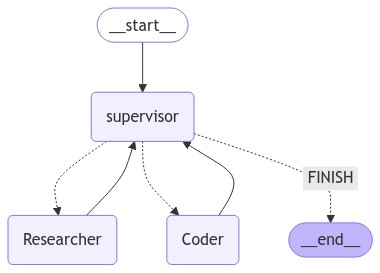

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can test the graph created

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='The program printed: \n\nHello, World!', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='### Research Report on Pikas\n\n#### Introduction\nPikas, small mammals belonging to the family Ochotonidae, are adapted for life in alpine and rocky environments. Known for their high metabolic rate and dense fur, pikas face significant challenges due to climate change. This report summarizes recent research efforts focused on understanding the impact of environmental changes on pika populations through innovative methods such as DNA analysis from feces.\n\n#### Current Research Focus\nRecent studies have highlighted new techniques in tracking pika populations by utilizing their genetic material, specifically DNA found in excrement (poop). Researchers like Kate Arpin and her team at the Russello Lab are developing methodologies to trace individual pikas and assess population connectivity. This approach is particularly useful for monitoring species affected by climate change, providing insigh

## Hierarchical Agent Teams

In some tasks that are too complex, is it necessary to have more than one supervisor node. In these tytpe of systems, we compose different subgraphs and create a top-level supervisor, along with mid-level supervisors.

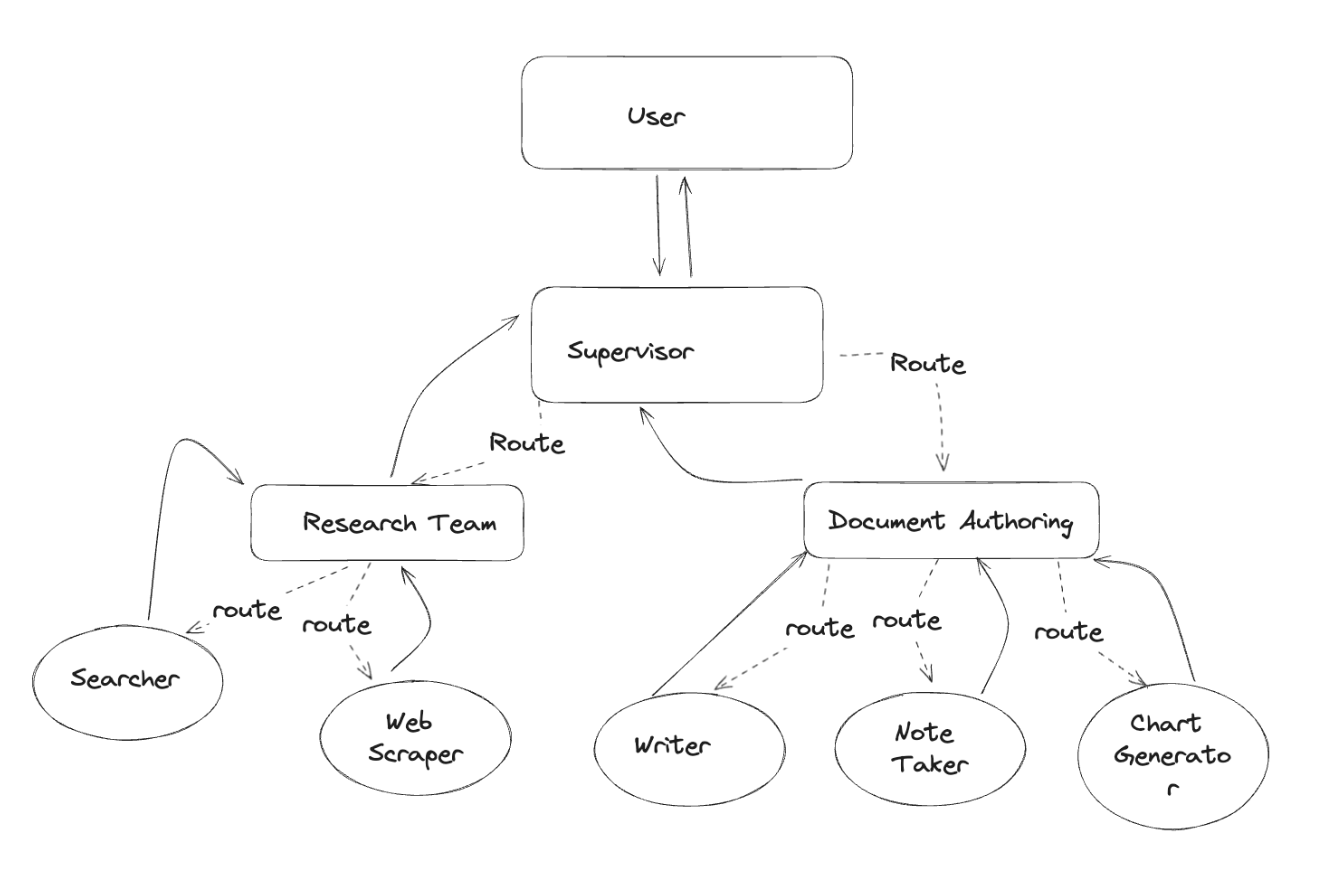

In this example, we will have two teams. We will start by defining the tools for the research team.

In [152]:
from typing import Annotated, List
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool

research_tool = DuckDuckGoSearchResults(max_results=10, output_format="list")

@tool
def scrape_webpages(urls:List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

The next step is to define the tools for the document writing team tools.

In [153]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."]
)->Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline"""
    with (WORKING_DIRECTORY/file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None
):
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."]
)-> Annotated[str, "Path of the saved document file"]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"


After creating the tools, we define the method to execute an agent node, as well as the method to create a supervisor agent.

In [154]:
from langchain_core.messages import trim_messages
from langchain_core.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal
from langchain_core.output_parsers import BaseOutputParser

# Define the method to execute an agent node
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

# REVISAR SI BORRAR ESTE CÓDIGO


# Define the method to create a supervisor agent
def create_team_supervisor(llm, system_prompt, members) -> str:
    """An LLM-based router."""
    trimmer = trim_messages(
        max_tokens=100000,
        strategy="last",
        token_counter=llm,
        include_system=True
    )
    options = ["FINISH"]+members # Define the options that can be selected by the router
    class DictOutputParser(BaseOutputParser):
        """Parser que asegura que la salida sea un diccionario con la clave 'next'."""

        def parse(self, text: str) -> dict:
            # Verifica que la salida sea una cadena esperada y conviértela en un diccionario
            return {"next": text.strip()}  # Asegúrate de eliminar cualquier espacio en blanco adicional
            
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who sould act next?"
                "Or should we FINISH? Select one of: {options}"
            )
        ]
    ).partial(options=str(options), team_members=",".join(members))
    #llm.bind(tools=function_def) fucntion_call="route"
    return prompt | trimmer | llm.bind(tools=[function_def], function_call="route") | DictOutputParser()


Now, we can define out hierarchical teams. **We start by the research team**.

In [155]:
from langchain_core.messages import BaseMessage, HumanMessage
import operator
from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent
import functools
from typing_extensions import TypedDict


class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of the other's skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function that will update this every time it makes a decision
    next: str


llm = ChatOllama(model="qwen2.5:14b", temperature=0)
search_agent = create_react_agent(llm, tools=[research_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(llm=llm,
                                        system_prompt="You are a supervisor tasked with managing a conversation between the"
                                            " following workers:  Search, WebScraper. Given the following user request,"
                                            " respond with the worker to act next. Each worker will perform a"
                                            " task and respond with their results and status. When finished,"
                                            " respond with FINISH.",
                                        members=["Search", "WebScraper"])



Finally, we create the graph for the research team.

In [156]:
from langgraph.graph import END, StateGraph, START

research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)

research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()

# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

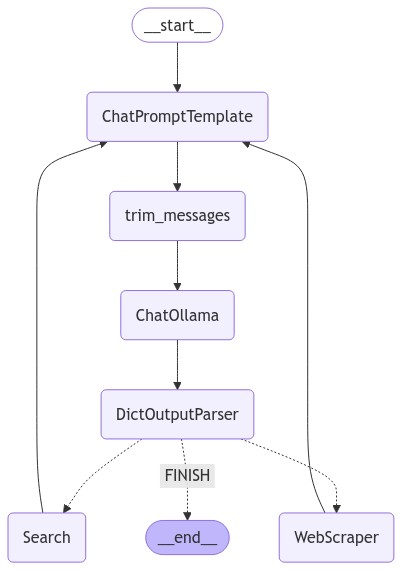

In [157]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [158]:
for s in research_chain.stream(
    "when is Taylor Swift's next tour?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='Taylor Swift\'s next tour is called "The Eras Tour," which will take place in 2024. The tour includes multiple dates across the United States and the UK. For instance, she has scheduled three nights at Hard Rock Stadium in Miami Gardens, Florida on October 18th, 19th, and 20th, 2024.\n\nYou can find more details about the tour including all concert dates, venues, setlists, and ticket information on her official website or Ticketmaster. Here are some links to get you started:\n- [Taylor Swift\'s Official Tour Page](https://www.taylorswift.com/tour-us/)\n- [Ticketmaster - Taylor Swift Tickets](https://www.ticketmaster.com/taylor-swift-tickets/artist/1094215)\n\nFor the most up-to-date information, it’s best to visit these sites directly.', additional_kwargs={}, response_metadata={}, name='Search')]}}
---


KeyError: ''

Now, we continue with the writing teams.

In [ ]:
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str

# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

llm = ChatOllama(model="qwen2.5:14b", temperature=0)
# Create the writer agent
doc_writer_agent = create_react_agent(
    llm, tools=[write_document, edit_document, read_document]
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

# Create the note taking agent
note_taking_agent = create_react_agent(llm, tools=[create_outline, read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

# Create the chart generating agent
chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

# Create the supervisor
doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

Finally, we can create the graph 

In [ ]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

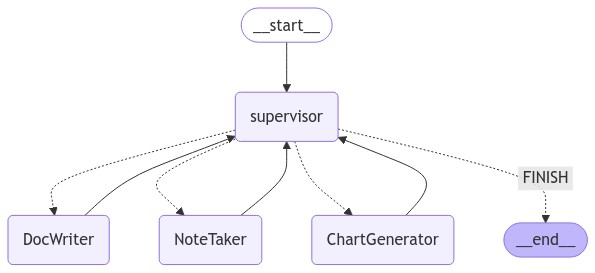

In [ ]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
doc_writing_supervisor.invoke({"messages": [HumanMessage(content="Write an outline for poem and then write the poem to disk.")]})

{'next': ''}

In [ ]:
for s in authoring_chain.stream(
    "Write an outline for poem and then write the poem to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

KeyError: ''